In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from tqdm import tqdm
import os
import datetime
import matplotlib.dates as mdates
from chinese_calendar import is_holiday, is_workday
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns
"""
降雨分析：将日降雨量≥5mm定义为下雨天，分析降雨对工作日和节假日客流的影响
温度分析：分析日平均温度与客流量的线性相关关系
可视化：用箱线图展示降雨影响，用散点图展示温度影响
统计检验：计算相关系数和p值，评估统计显著性
"""

In [2]:
stationInfo = pd.read_csv('../Data/stationInfo.csv')
dict_staionName = dict(zip(stationInfo['stationID'], stationInfo['name']))
dict_stationLoc = dict(zip(stationInfo['stationID'], zip(stationInfo['lon'],stationInfo['lat'])))
stationID_List = list(stationInfo['stationID'])
root_path = '../Data' 
raw_data = pd.read_csv(os.path.join(root_path, 'metroData_InOutFlow.csv'))
raw_data

,date,timeslot,startTime,endTime,station,inFlow,outFlow,CinFlow,HBOinFlow,NHBinFlow,CoutFlow,HBOoutFlow,NHBoutFlow
0,20170501,0,60000,61000,112,29,32,9,15,5,11,13,8
1,20170501,0,60000,61000,113,142,102,40,51,51,30,41,31
2,20170501,0,60000,61000,114,66,35,17,19,30,12,10,13
3,20170501,0,60000,61000,119,23,14,6,9,8,1,3,10
4,20170501,0,60000,61000,124,17,21,2,4,11,0,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788887,20170831,12545,225000,230000,2053,6,26,2,0,4,8,6,12
3788888,20170831,12545,225000,230000,2054,18,110,5,2,11,19,39,52
3788889,20170831,12545,225000,230000,2055,5,80,0,1,4,19,23,38
3788890,20170831,12545,225000,230000,2056,33,99,8,4,21,20,31,48


In [3]:
totalFlow = [] # 线网总流量（每天）
dayList = []

curr_date = 20170501
currDayFlow = 0
for line in tqdm(raw_data.values):
    if curr_date != line[0]:
        totalFlow.append(currDayFlow)
        dayList.append(curr_date)
        curr_date = line [0]
        
        currDayFlow = 0

    currDayFlow += line[5] 

totalFlow.append(currDayFlow)
dayList.append(curr_date)
totalFlow = np.array(totalFlow)

100%|██████████| 3788892/3788892 [00:02<00:00, 1574879.57it/s]


In [4]:
workdayIdxList = [] # idx for date in dayList
holidayIdxList = []
for idx, tF in enumerate(totalFlow):
    if tF< 2*1e6:
        print(dayList[idx])
        continue
    elif is_workday(datetime.datetime.strptime(str(dayList[idx]),'%Y%m%d')):
        workdayIdxList.append(idx)
    else:
        holidayIdxList.append(idx)
print(len(workdayIdxList))
print(len(holidayIdxList))

20170504
20170508
20170509
20170616
20170627
20170628
81
36


In [7]:
def corrWithWeather(totalFlow, workdayIdxList, holidayIdxList, dayList):
    weatherData = pd.read_csv('../Data/MetaData/shanghai_weatherDaily.csv')

    day2Rain =  dict(zip(weatherData['date'], weatherData['precipitation_sum']))
    day2Temp =  dict(zip(weatherData['date'], weatherData['temperature_2m_mean']))

    for k,v in day2Rain.items(): # turn Rainy to 0-1
        if v>=5:
            day2Rain[k] = 1
        else:
            day2Rain[k] = 0

    workdayFlow = [totalFlow[i] for i in workdayIdxList]
    holidayFlow = [totalFlow[i] for i in holidayIdxList]

    # Rain
    workdayRain = [day2Rain[dayList[idx]] for idx in workdayIdxList]
    holidayRain = [day2Rain[dayList[idx]] for idx in holidayIdxList]
    r_workday, p_workday = stats.pointbiserialr(workdayRain, workdayFlow) # Point-biserial correlation
    r_holiday, p_holiday = stats.pointbiserialr(holidayRain, holidayFlow)
    print('for workday flow and rain, r={}, p={}'.format(r_workday, p_workday))
    print('for holiday flow and rain, r={}, p={}'.format(r_holiday, p_holiday))

    workdayFlowbox = [[],[]]
    for idx, flow in enumerate(workdayFlow):
        workdayFlowbox[workdayRain[idx]].append(flow)

    holidayFlowbox = [[],[]]
    for idx, flow in enumerate(holidayFlow):
        holidayFlowbox[holidayRain[idx]].append(flow)

    fig, axis = plt.subplots(2,2, figsize=(10, 10), dpi=300)
    axis[0,0].boxplot(x=workdayFlowbox,tick_labels =['<5mm','≥5mm'] ,patch_artist=False, showfliers=False,showmeans=False, medianprops=dict(linewidth=0), zorder=0)
    for i, data in enumerate(workdayFlowbox): # draw datapoints
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        axis[0,0].scatter(x_positions, data, color='black', alpha=0.3, s=3, zorder=1) 
    axis[0,0].set_title('Workday', fontsize=20)
    axis[0,0].set_xlabel('24h Precipitation Sum',fontsize=12)
    axis[0,0].set_ylabel('')
    axis[0,0].text(0.95, 0.8, 'corr='+str(round(r_workday,2))+'\n p='+str(round(p_workday,3)),ha='right',va='bottom', linespacing=2, multialignment='left',transform=axis[0,0].transAxes,fontsize=12
    ,bbox=dict(facecolor='white', edgecolor='black'))
    axis[0,0].tick_params(labelsize=12)

    axis[0,1].boxplot(x=holidayFlowbox,tick_labels =['<5mm','≥5mm'] ,patch_artist=False, showfliers=False,showmeans=False, medianprops=dict(linewidth=0), zorder=0)
    for i, data in enumerate(holidayFlowbox): # draw datapoints
        x_positions = np.random.uniform(i+0.95, i+1.05, size=len(data))  
        axis[0,1].scatter(x_positions, data, color='black', alpha=0.3, s=3, zorder=1) 
    axis[0,1].set_title('Holiday', fontsize=20)
    axis[0,1].set_xlabel('24h Precipitation Sum',fontsize=12)
    axis[0,1].set_ylabel('')
    axis[0,1].text(0.95, 0.8, 'corr='+str(round(r_holiday,2))+'\n p='+str(round(p_holiday,3)),ha='right',va='bottom', linespacing=2, multialignment='left',transform=axis[0,1].transAxes,fontsize=12
    ,bbox=dict(facecolor='white', edgecolor='black'))
    axis[0,1].tick_params(labelsize=12)

#######################

    # Temp 
    workdayTemp = [day2Temp[dayList[idx]] for idx in workdayIdxList]
    holidayTemp = [day2Temp[dayList[idx]] for idx in holidayIdxList]
    # corr_workdayTemp = np.corrcoef(workdayFlow, workdayTemp)[0,1]
    # corr_holidayTemp = np.corrcoef(holidayFlow, holidayTemp)[0,1]
    corr_workdayTemp, p_workdayTemp = pearsonr(workdayFlow, workdayTemp)
    corr_holidayTemp, p_holidayTemp = pearsonr(holidayFlow, holidayTemp)
    print(f"工作日流量与温度相关系数: {corr_workdayTemp}, P值: {p_workdayTemp}")
    print(f"假日流量与温度相关系数: {corr_holidayTemp}, P值: {p_holidayTemp}")

    axis[1,0].scatter(workdayTemp,workdayFlow, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
    axis[1,0].set_ylabel('')
    axis[1,0].set_xlabel('Temperature',fontsize=12)
    axis[1,0].spines['top'].set_visible(False)
    axis[1,0].spines['right'].set_visible(False)
    axis[1,0].text(0.95, 0.8, 'corr='+str(round(corr_workdayTemp,2))+'\n p<0.01',ha='right',va='bottom', linespacing=2, multialignment='left',transform=axis[1,0].transAxes,fontsize=12
    ,bbox=dict(facecolor='white', edgecolor='black'))
    coefficients = np.polyfit(workdayTemp,workdayFlow, 1)  
    poly = np.poly1d(coefficients)
    x_reg = np.array([min(workdayTemp), max(workdayTemp)])  
    axis[1,0].plot(x_reg, poly(x_reg), 'r-',zorder=0)  
    axis[1,0].tick_params(labelsize=12)

    axis[1,1].scatter(holidayTemp,holidayFlow, s=10, facecolor='green', edgecolors='black', linewidths=0.5)
    axis[1,1].set_ylabel('')
    axis[1,1].set_xlabel('Temperature',fontsize=12)
    axis[1,1].spines['top'].set_visible(False)
    axis[1,1].spines['right'].set_visible(False)
    axis[1,1].text(0.95, 0.8, 'corr='+str(round(corr_holidayTemp,2))+'\n p<0.01',ha='right',va='bottom', linespacing=2, multialignment='left',transform=axis[1,1].transAxes,fontsize=12
    ,bbox=dict(facecolor='white', edgecolor='black'))
    coefficients = np.polyfit(holidayTemp,holidayFlow, 1)  
    poly = np.poly1d(coefficients)
    x_reg = np.array([min(holidayTemp), max(holidayTemp)])  
    axis[1,1].plot(x_reg, poly(x_reg), 'r-', zorder=0)  
    axis[1,1].tick_params(labelsize=12)

    fig.supylabel('#Ridership', fontsize=16, y=0.5)
    plt.savefig('../results/weather_corr.pdf',dpi=300)


for workday flow and rain, r=-0.09537198263240856, p=0.39702880340908
for holiday flow and rain, r=-0.3049721599620326, p=0.07051089602285526
工作日流量与温度相关系数: -0.46836808099620914, P值: 1.0361166197244677e-05
假日流量与温度相关系数: -0.5351967955348008, P值: 0.0007702178884859223


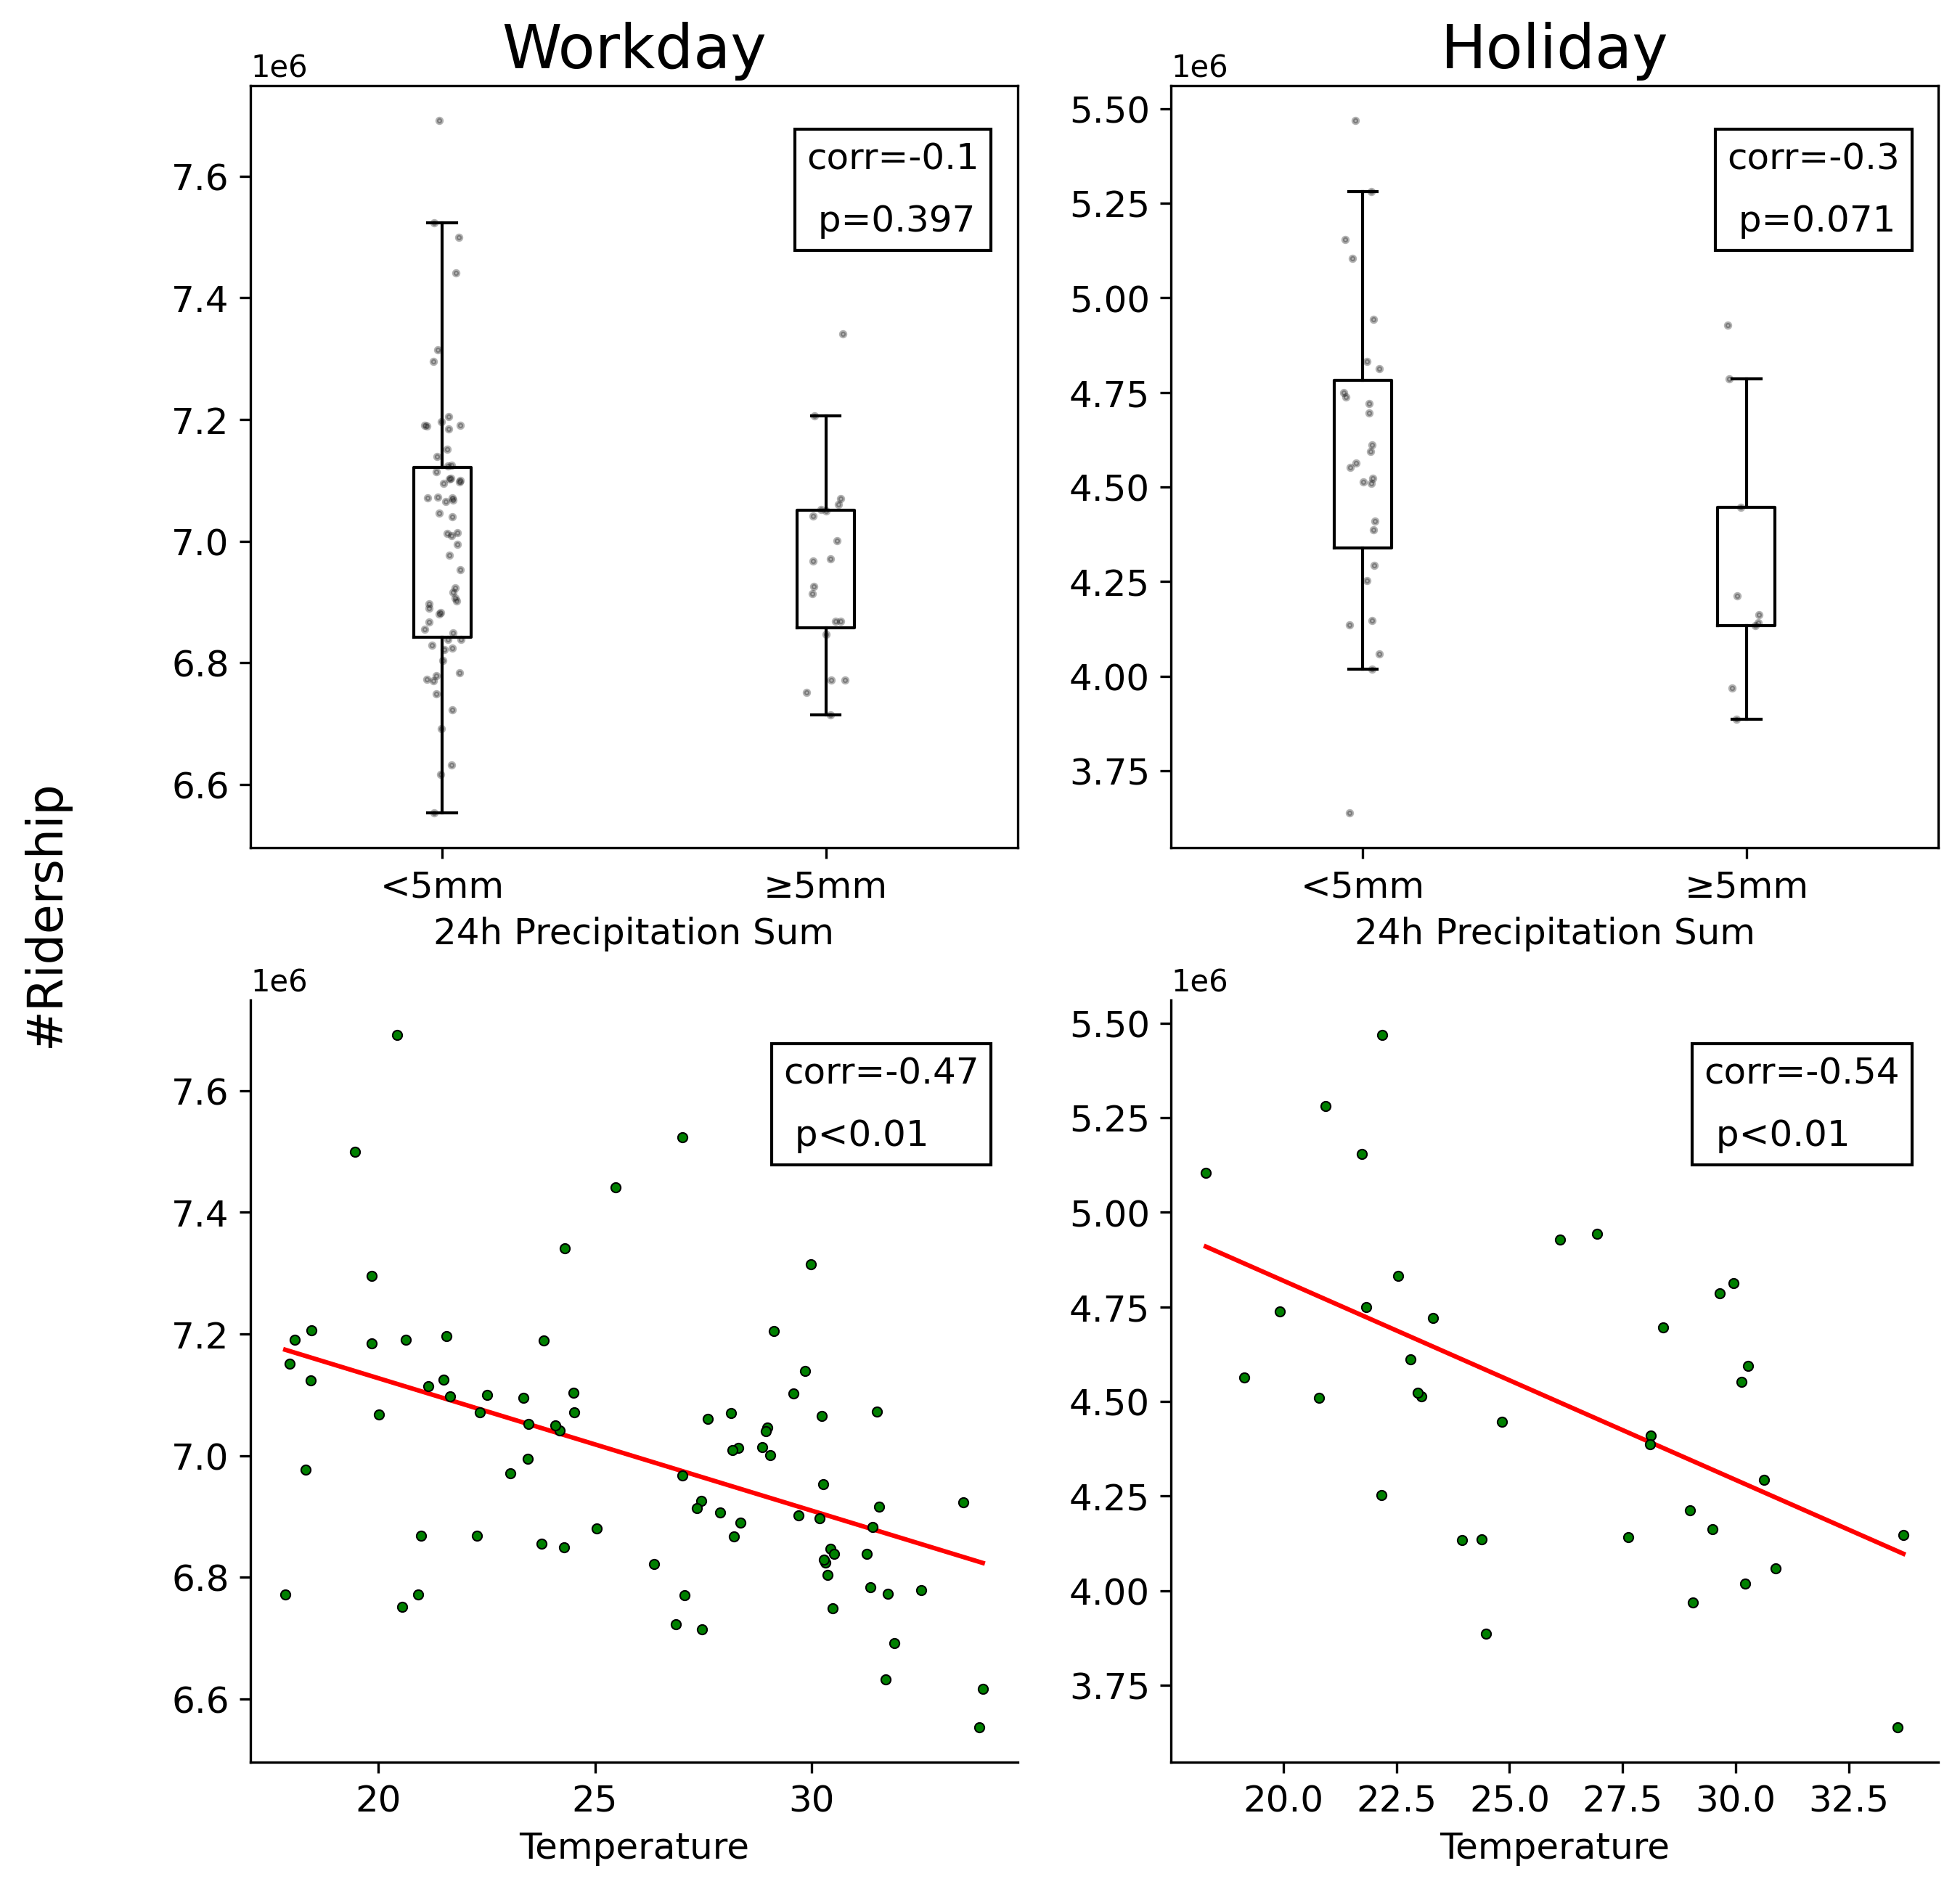

In [8]:
corrWithWeather(totalFlow, workdayIdxList, holidayIdxList, dayList)

***
6 月 10 日上海暴雨黄色警报

In [21]:
def WeatherEventData(raw_data, stationID_List, dict_staionName, dict_stationLoc):

    eventDayFlow = {}  # container：6月10日, 各站点分小时流量 
    avgDayFlow = {}    # container: 6月非工作日，各站点的分小时平均流量
    holidayCount = 0

    for stationID in stationID_List:
        eventDayFlow[stationID] = [0] * 17 # 6:00-23:00 
        avgDayFlow[stationID] = [0] * 17
    
    curr_date = '20170501'
    dateObj = datetime.datetime.strptime(curr_date, '%Y%m%d')
    holidayCache = '20170501'
    for line in tqdm(raw_data.values):
        if str(line[0]) != curr_date: 
            dateObj = datetime.datetime.strptime(str(line[0]), '%Y%m%d')
            curr_date = str(line[0])
        if dateObj.month == 6:
            if is_holiday(dateObj):
                if str(line[0]) != holidayCache:
                    holidayCount += 1
                    holidayCache = str(line[0])
                stationID = line[4]
                hour = int(line[2]//10000)
                avgDayFlow[stationID][hour-6] += line[5] 
                if str(line[0]) == '20170610':
                    eventDayFlow[stationID][hour-6] += line[5] 

    for stationID, stationFlow in avgDayFlow.items():
        avgDayFlow[stationID] = [float(i)/holidayCount for i in stationFlow]

    print(holidayCount)
    
 #读取数据，不要使用 .values
    weatherDataV2 = pd.read_csv('../Data/MetaData/shanghai_weatherHourly.csv')

# 转换日期格式
    weatherDataV2['date'] = pd.to_datetime(weatherDataV2['date'], format='%Y%m%d %H:%M:%S')

    rainFall = [0] * 17   # 6:00-23:00

    for index, row in tqdm(weatherDataV2.iterrows(), total=len(weatherDataV2)):
    # 检查日期是否为2017-06-10
        if row['date'].date() != datetime.date(2017, 6, 10):
            continue
    
        hour = row['date'].hour
        if 6 <= hour <= 22:
        # 假设降水量在倒数第二列，使用正确的列名或索引
            rainFall[hour-6] = row.iloc[-2]  # 或者使用具体的列名，如 row['rainfall']

    return eventDayFlow, avgDayFlow, rainFall


def drawWeatherEvent(eventDayFlow, avgDayFlow, rainFall):
    targetStationIDList = [1163, 1628, 643] # 迪士尼，野生动物园，五洲大道
    
    x_ticks =  [str(i)+':00' for i in range(6,23)]
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, dpi=300)


    for i, ax in enumerate(axes):
        ax.set_facecolor('#FFEECE')
        ax.grid(True, color='white', linestyle='-', linewidth=1)

        stationID = targetStationIDList[i]
        line1, = ax.plot(x_ticks, eventDayFlow[stationID], 'k-o', label='2017-06-10',zorder=3)
        line2, = ax.plot(x_ticks, avgDayFlow[stationID], '--^', color='gray', alpha=0.5, label='Monthly Average',zorder=2)
        

        ax.tick_params(axis='y', labelcolor='black',labelsize=15)
        
        ax2 = ax.twinx()
        bars = ax2.bar(x_ticks, rainFall, alpha=0.5, color='#2486b9', label='Precipitation',zorder=1)

        ax.set_xticks(x_ticks[::2]) 
        ax.set_xticklabels(x_ticks[::2],fontsize=15) 
        
        ax2.set_ylabel('mm',fontsize=15)
        ax2.tick_params(axis='y', labelcolor='black',labelsize=15)

        ax.set_title(f'Station #{stationID}',fontsize=15)
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()


    axes[-1].set_xlabel('Hour',fontsize= 20) 
    fig.legend([line1, line2, bars], ['2017-06-10','Monthly Average','Precipitation'], loc='upper center', bbox_to_anchor=(0.5, 1.005),  ncol=3,fontsize=16)
    fig.supylabel('#Ridership', fontsize=20, y=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the legend
    plt.savefig('../results/weather_event.pdf',dpi=300)

    return 0
        

In [22]:
eventDayFlow, avgDayFlow, rainFall = WeatherEventData(raw_data, stationID_List, dict_staionName, dict_stationLoc)

100%|██████████| 3788892/3788892 [00:28<00:00, 132677.65it/s] 


8


100%|██████████| 2952/2952 [00:01<00:00, 2762.09it/s]


0

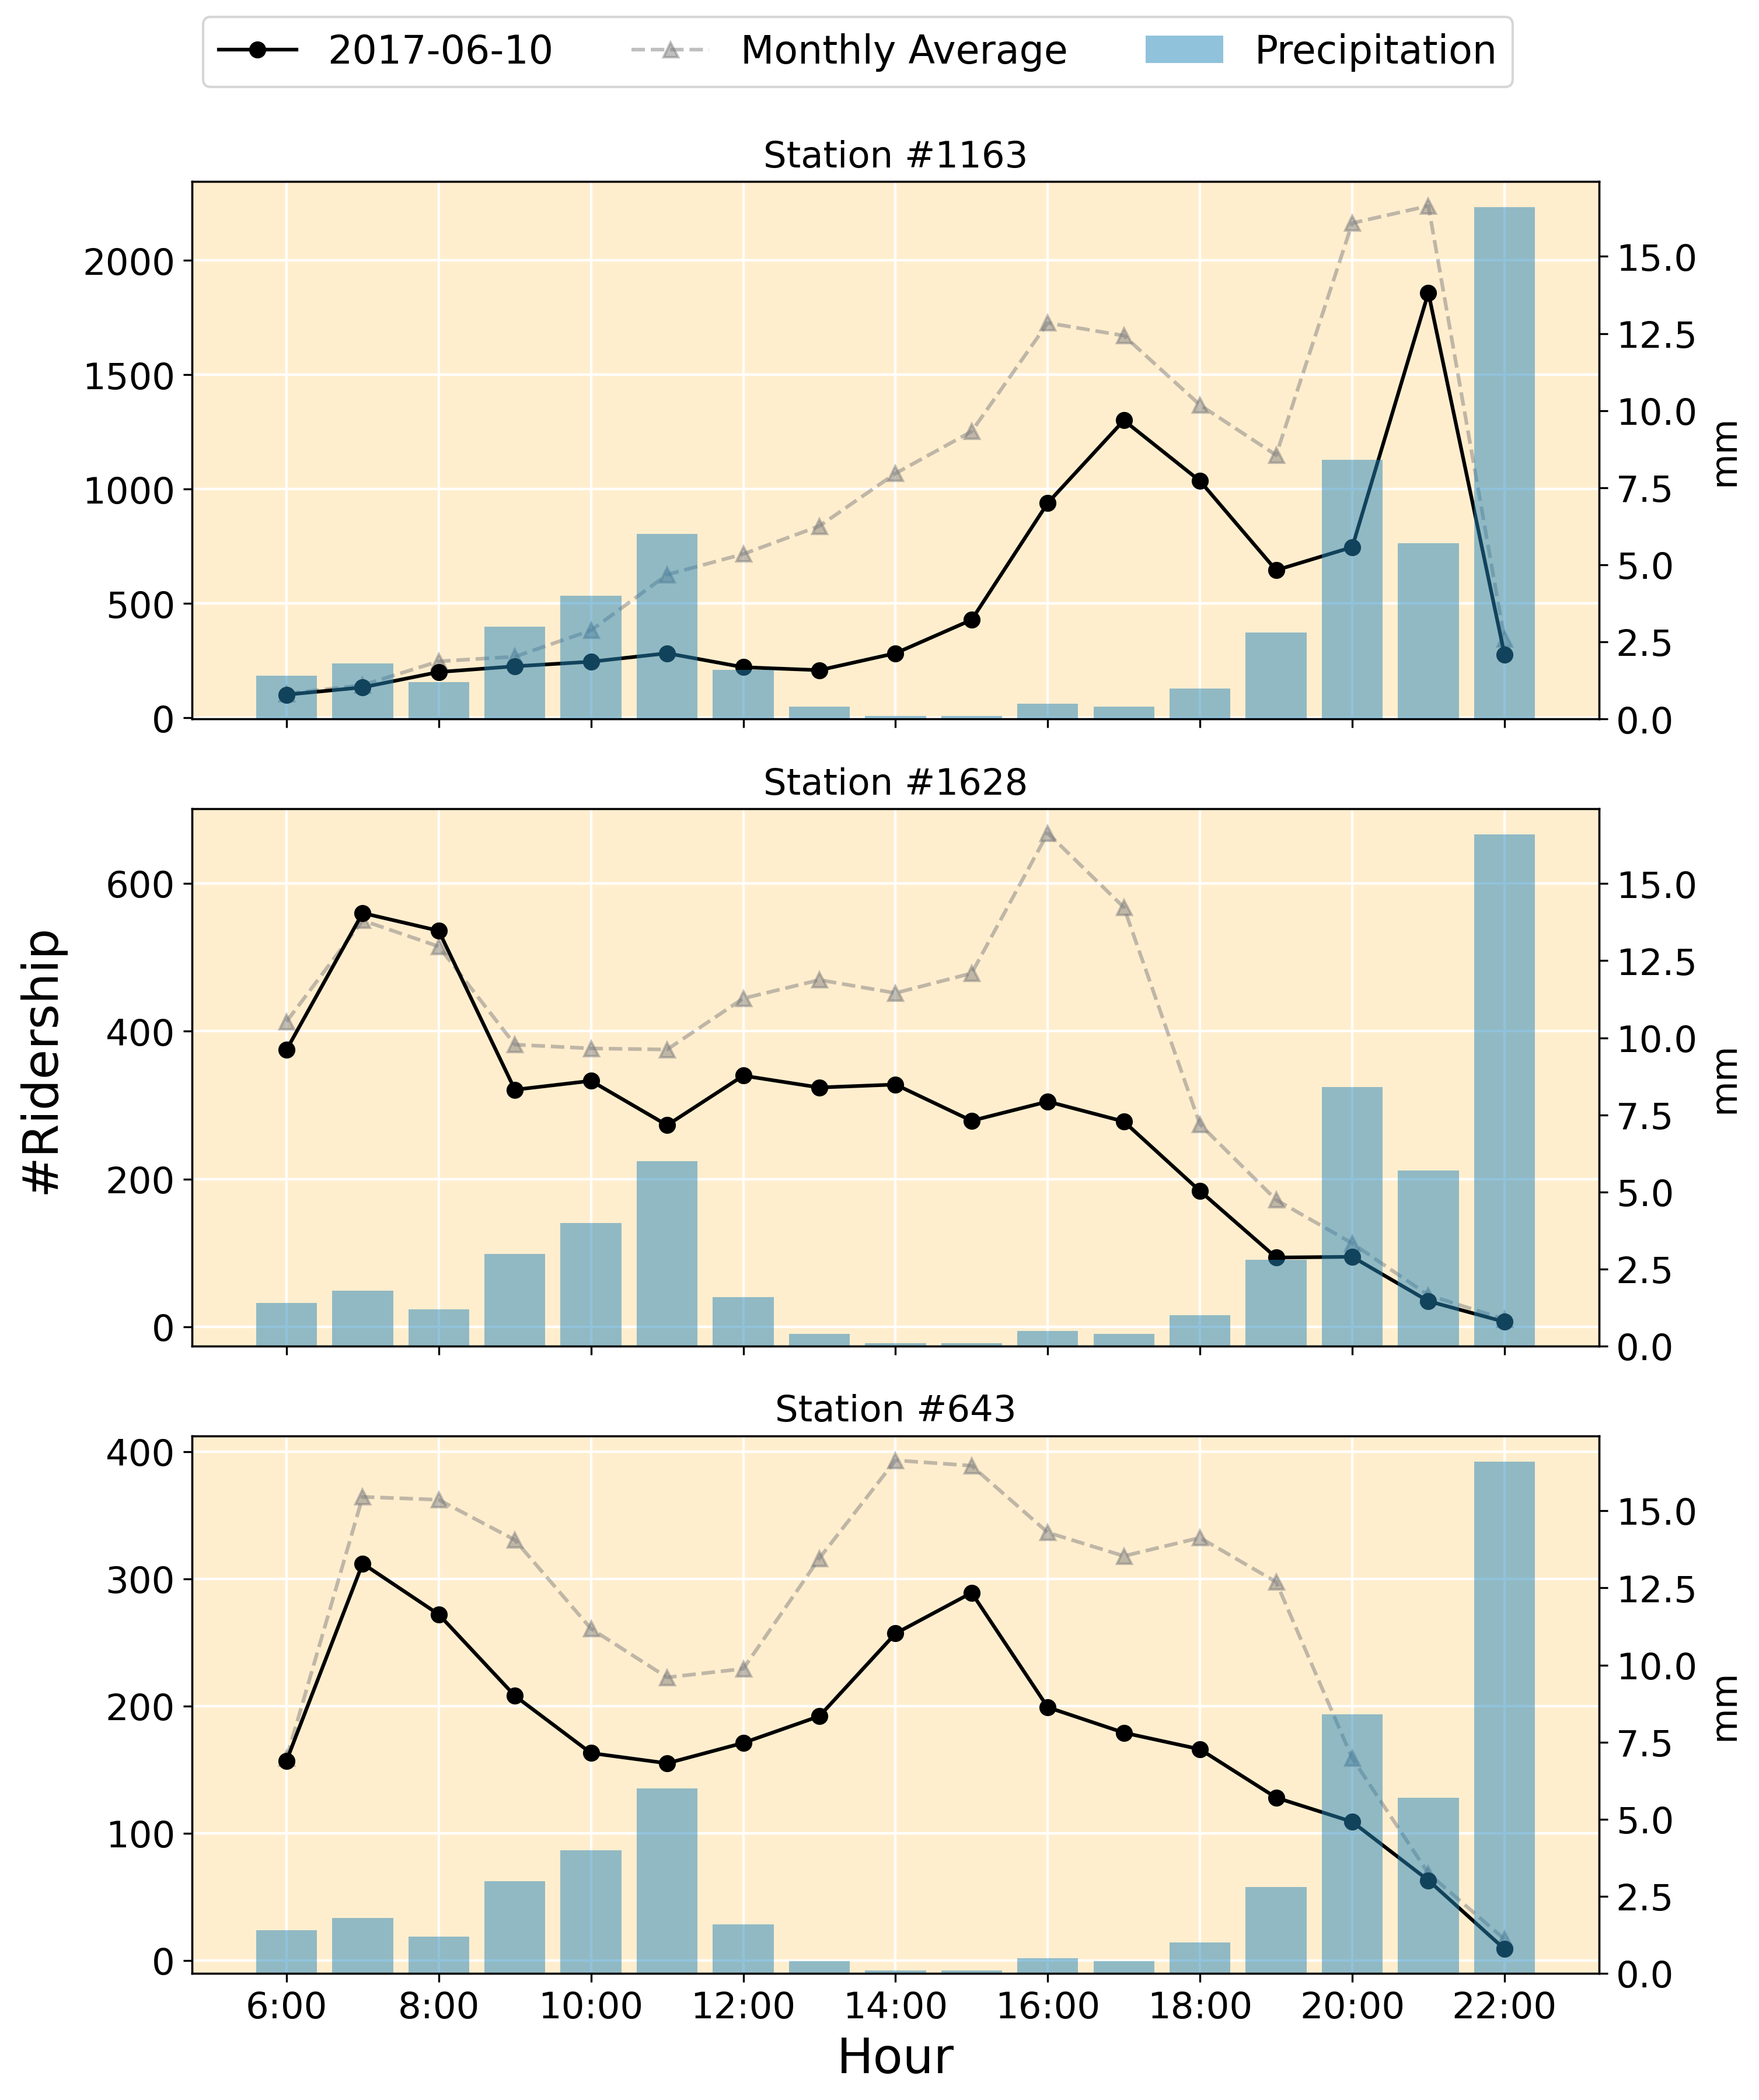

In [ ]:
drawWeatherEvent(eventDayFlow, avgDayFlow, rainFall)
"""
2. 极端天气事件案例分析
案例1：6月10日暴雨事件
背景：上海暴雨黄色警报日
对比分析：比较暴雨当天与6月节假日平均客流
重点站点：迪士尼、野生动物园、五洲大道等旅游/郊区站点
结果：计算各站点客流下降率，统计受影响站点数量
案例2：7月3日工作日中雨事件
背景：工作日的中等降雨
特殊关注：分析通勤流量(CFlow)的变化
重点站点：莘庄、顾村、七宝等住宅区站点
发现：通勤流量比月均值略有增加，但增幅不大
3. 主要发现
降雨影响规律：

节假日受降雨影响更显著（相关系数-0.49 vs -0.19）
工作日通勤需求相对刚性，受天气影响较小
温度影响：

高温天气普遍减少地铁出行
节假日对温度更敏感
极端事件影响：

暴雨天气显著减少休闲出行
工作日降雨对通勤影响有限
这种分析对地铁运营调度、应急预案制定、以及理解城市交通韧性都有重要价值。
"""

[np.float64(0.08606268709279803), np.float64(0.020315044540003453), np.float64(0.10201700883566527), np.float64(0.05050908085442982), np.float64(0.16098213762205155), np.float64(0.17034921710510395), np.float64(0.053709159455472805), np.float64(0.09194017665256594), np.float64(0.12416357194507785), np.float64(0.047638542981588254), np.float64(0.08366672464776483), np.float64(0.18252914268850523), np.float64(0.2876249662253445), np.float64(0.10499410145497444), np.float64(0.026119402985074626), np.float64(0.0977552903027423), np.float64(0.09107726459887772), np.float64(0.2597938144329897), np.float64(0.08683473389355742), np.float64(0.16509677117015792), np.float64(0.24626296134238296), np.float64(0.04505312233827946), np.float64(0.20988067358090778), np.float64(0.07951356407857811), np.float64(0.0638063156235841), np.float64(0.07994172867565721), np.float64(0.12780822490900723), np.float64(0.09696634472195038), np.float64(0.09054555841188232), np.float64(0.18136092186054337), np.float6

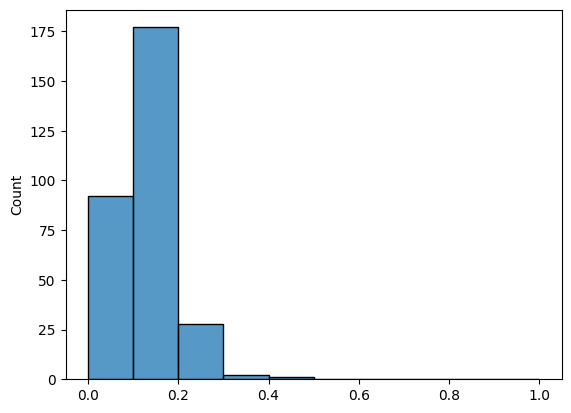

In [24]:
# statistical analysis
# calculate the total flow drop rate for each station
dropRate = []
for stationID in stationID_List:
    dropRate.append((np.sum(avgDayFlow[stationID])-np.sum(eventDayFlow[stationID]))/np.sum(avgDayFlow[stationID]))
print(dropRate)
sns.histplot(dropRate, bins=np.arange(0, 1.1, 0.1), edgecolor='black')

threshold = 0.1
dropStationCount = np.sum(np.array(dropRate) > threshold)
print(dropStationCount)

***
顺便看下 7.3（工作日的中雨），重点关注cflow

In [29]:
def WeatherEventDataWorkday(raw_data, stationID_List, dict_staionName, dict_stationLoc):

    eventDayFlow = {}  # container：7月03日, 各站点分小时流量 
    avgDayFlow = {}    # container: 7月各工作日，各站点的分小时平均流量
    eventDayCFlow = {}
    avgDayCFlow = {}
    workdayCount = 0

    for stationID in stationID_List:
        eventDayFlow[stationID] = [0] * 17 # 6:00-23:00 
        avgDayFlow[stationID] = [0] * 17
        eventDayCFlow[stationID] = [0] * 17
        avgDayCFlow[stationID] = [0] * 17
    
    curr_date = '20170501'
    dateObj = datetime.datetime.strptime(curr_date, '%Y%m%d')
    workdayCache = '20170502'
    for line in tqdm(raw_data.values):
        if str(line[0]) != curr_date: 
            dateObj = datetime.datetime.strptime(str(line[0]), '%Y%m%d')
            curr_date = str(line[0])
        if dateObj.month == 7:
            if is_workday(dateObj):
                if str(line[0]) != workdayCache:
                    workdayCount += 1
                    workdayCache = str(line[0])
                stationID = line[4]
                hour = int(line[2]//10000)
                avgDayFlow[stationID][hour-6] += line[5]
                avgDayCFlow[stationID][hour-6] += line[7]
                if str(line[0]) == '20170703':
                    eventDayFlow[stationID][hour-6] += line[5]
                    eventDayCFlow [stationID][hour-6] += line[7]

    for stationID, stationFlow in avgDayFlow.items():
        avgDayFlow[stationID] = [float(i)/workdayCount for i in stationFlow]
    
    for stationID, stationFlow in avgDayCFlow.items():
        avgDayCFlow[stationID] = [float(i)/workdayCount for i in stationFlow]

    print(workdayCount)
    
    # 提取 6 月 10 日 各个小时的降水量 
    weatherDataV2 = pd.read_csv('../Data/MetaData/shanghai_weatherHourly.csv').values
    rainFall = [0] * 17   # 6:00-23:00

    for line in tqdm(weatherDataV2):
        MydateTime = datetime.datetime.strptime(line[0], '%Y%m%d %H:%M:%S')
        if line[0][:10] != '20170703':
            continue
        else:
            hour = MydateTime.hour
            if hour <=22 and hour >=6:
                rainFall[hour-6] = line[-2]

    return eventDayFlow, avgDayFlow, eventDayCFlow, avgDayCFlow, rainFall


def drawWeatherEventWorkday(eventDayFlow, avgDayFlow, eventDayCFlow, avgDayCFlow, rainFall):
    targetStationIDList = [2011, 725, 928] # 莘庄，顾村，七宝
    
    x_ticks =  [str(i)+':00' for i in range(6,23)]
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, dpi=300)


    for i, ax in enumerate(axes):
        ax.set_facecolor('#FFEECE')
        ax.grid(True, color='white', linestyle='-', linewidth=1)

        stationID = targetStationIDList[i]
        line1, = ax.plot(x_ticks, eventDayFlow[stationID], 'k-o', label='2017-06-10',zorder=3)
        line2, = ax.plot(x_ticks, avgDayFlow[stationID], '--^', color='gray', alpha=0.5, label='Monthly Average',zorder=2)
        line3, = ax.plot(x_ticks, eventDayCFlow[stationID],'k-o', color='green',zorder=5)
        line4, = ax.plot(x_ticks, avgDayCFlow[stationID],'-.', color='green', alpha=0.5, zorder=4)
        

        ax.tick_params(axis='y', labelcolor='black',labelsize=15)
        
        ax2 = ax.twinx()
        bars = ax2.bar(x_ticks, rainFall, alpha=0.5, color='#2486b9', label='Precipitation',zorder=1)

        ax.set_xticks(x_ticks[::2]) 
        ax.set_xticklabels(x_ticks[::2],fontsize=15) 
        
        ax2.set_ylabel('mm',fontsize=15)
        ax2.tick_params(axis='y', labelcolor='black',labelsize=15)

        ax.set_title(f'Station #{stationID}',fontsize=15)
        
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()


    axes[-1].set_xlabel('Hour',fontsize= 20) 
    fig.legend([line1, line2, bars], ['2017-07-03','Monthly Average','Precipitation'], loc='upper center', bbox_to_anchor=(0.5, 1.005),  ncol=3,fontsize=16)
    fig.supylabel('#Ridership', fontsize=20, y=0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for the legend
    plt.savefig('../results/weather_event_0703.pdf',dpi=300)

    return 0

In [30]:
eventDayFlow, avgDayFlow, eventDayCFlow, avgDayCFlow, rainFall = WeatherEventDataWorkday(raw_data, stationID_List, dict_staionName, dict_stationLoc)

100%|██████████| 3788892/3788892 [00:33<00:00, 112534.93it/s] 


21


100%|██████████| 2952/2952 [00:00<00:00, 47613.79it/s]


/tmp/ipykernel_2095/1194897389.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  line3, = ax.plot(x_ticks, eventDayCFlow[stationID],'k-o', color='green',zorder=5)
/tmp/ipykernel_2095/1194897389.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  line3, = ax.plot(x_ticks, eventDayCFlow[stationID],'k-o', color='green',zorder=5)
/tmp/ipykernel_2095/1194897389.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  line3, = ax.plot(x_ticks, eventDayCFlow[stationID],'k-o', color='green',zorder=5)


0

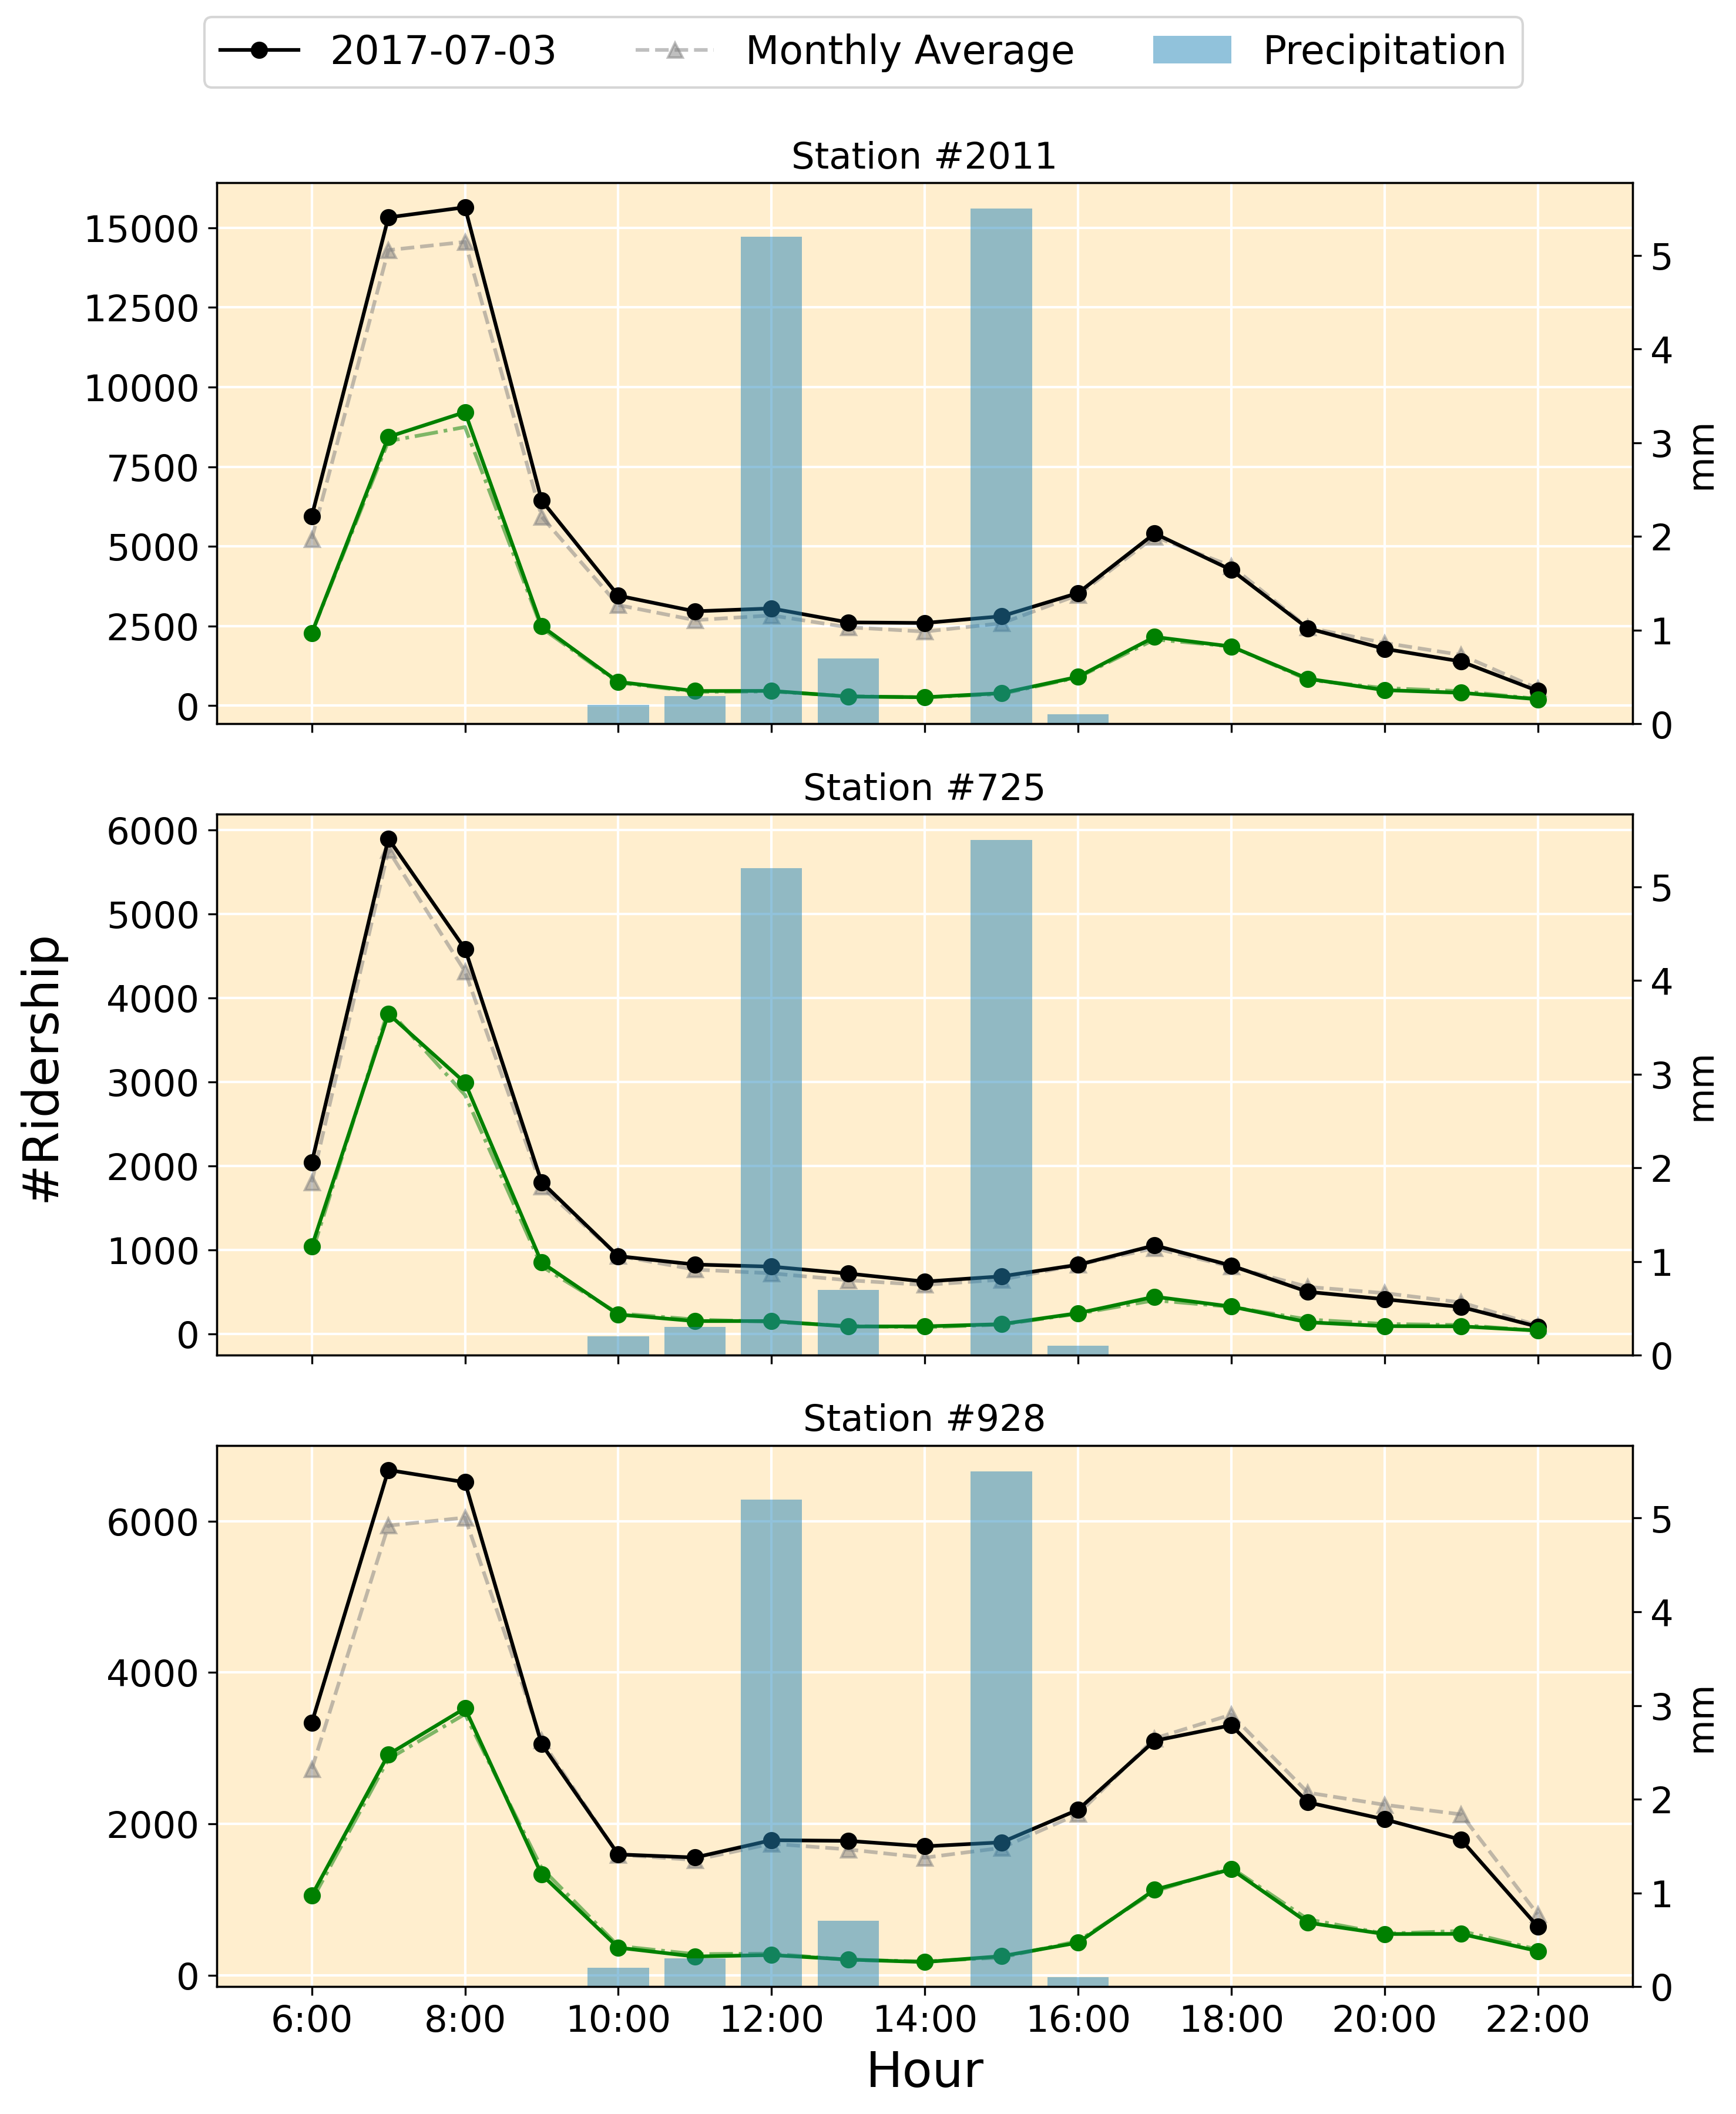

In [68]:
drawWeatherEventWorkday(eventDayFlow, avgDayFlow, eventDayCFlow, avgDayCFlow, rainFall)

没有发现这个pattern, cflow 比月均值多了但多的不多